# Setup
Importing files and importing libraries

In [92]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.5.0'

In [93]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

## Notes to self:
1. Images are in folder 'patch_images'

2. Dataset has the following columns: InstanceID, patientID, ImageName, cellTypeName, cellType, isCancerous
- data_labels_mainData.csv - has all the columns stated above
- data_labels_extraData.csv - does not have cellTypeName & cellType

Not sure how to deal with the extra dataset so I'll just use the main one first

In [94]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_labels_mainData.csv')

train_data_big, test_data_big = train_test_split(data, test_size=0.2, random_state=42)
train_data_big, val_data_big = train_test_split(train_data_big, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_big.shape[0], val_data_big.shape[0], test_data_big.shape[0]))
data.head()

Train data : 5937, Val Data: 1979, Test Data: 1980


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


Making the datasets smaller for faster processing speed (for now)

In [95]:
from sklearn.model_selection import train_test_split

_, train_data = train_test_split(train_data_big, test_size=0.1, random_state=42)
_, test_data = train_test_split(test_data_big, test_size=0.1, random_state=42)
_, val_data = train_test_split(val_data_big, test_size=0.1, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 594, Val Data: 198, Test Data: 198


# EDA
Definitely need to add more EDA

In [96]:
train_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
7873,5525,50,5525.png,epithelial,2,1
2790,8712,17,8712.png,epithelial,2,1
1828,13580,10,13580.png,epithelial,2,1
2370,3083,14,3083.png,epithelial,2,1
6048,20513,37,20513.png,fibroblast,0,0


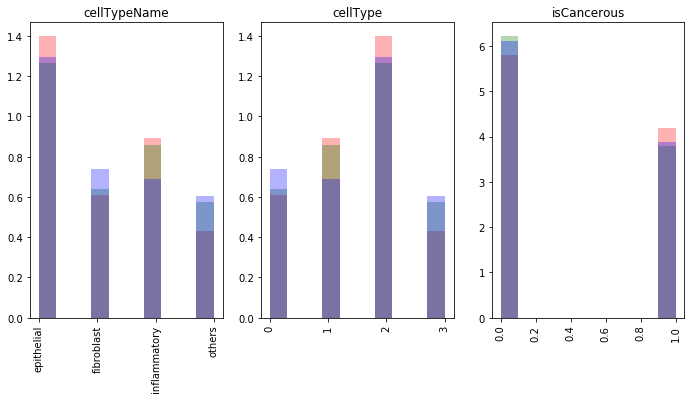

In [97]:
# plt.figure(figsize=(20,20))
# for i, col in enumerate(train_data.columns):
#     plt.subplot(4,5,i+1)
#     _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
#     _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
#     plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
#     plt.title(col)
#     plt.xticks(rotation='vertical')

plt.figure(figsize=(20,25))
for i, col in enumerate(['cellTypeName','cellType', 'isCancerous']):
    plt.subplot(4,5,i+1)
    _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
    _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
    plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

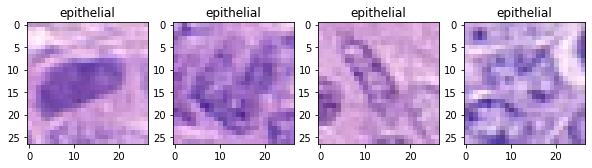

In [98]:
from PIL import Image

label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['cellType']
target_list = list(target)

fig = plt.figure(figsize=[10,10])

for i in np.arange(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

In [99]:
# check image size

img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


# Model Development
Our assignment has 2 parts:
- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous).
- Classify images according to cell-type, such as: fibroblast,inflammatory,epithelial or others.

I'll start with the 2nd point first - Classify images according to cell-type

### Initializing the model

In [100]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Mock Base Model
Just playing around, based on week 9 QnA + Lab (both pretty much the same)

In [101]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [102]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [103]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


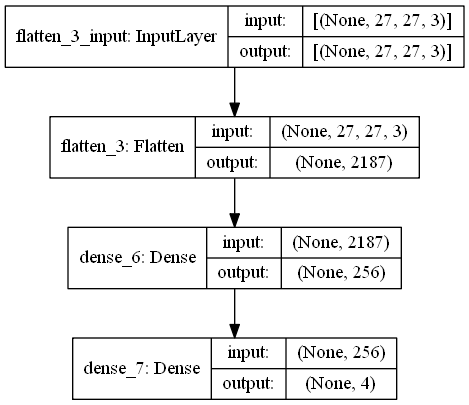

In [104]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [105]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

### Training the Model

In [106]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 4 classes.
Found 198 validated image filenames belonging to 4 classes.


In [108]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

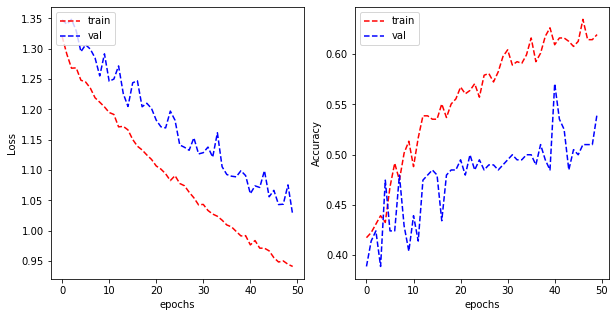

In [109]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [110]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [111]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [112]:
history_reg = model_reg.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

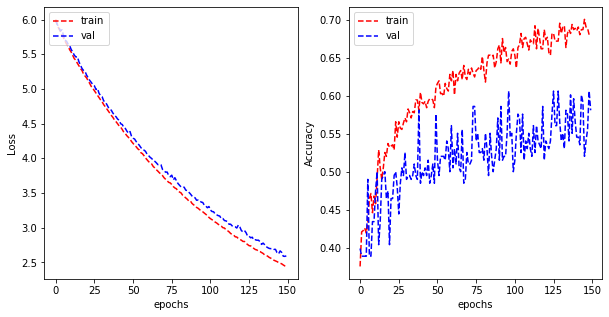

In [113]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Dropout

In [114]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [115]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [116]:
history_drop = model_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

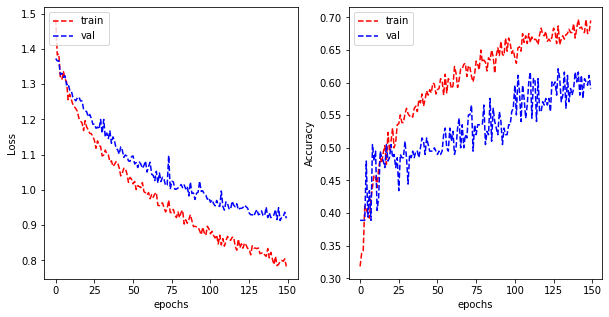

In [117]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Using keras-tuner to tune the model

In [118]:
!pip install -q -U keras-tuner

In [119]:
import kerastuner as kt

In [120]:
from tensorflow import keras
from tensorflow.keras import layers

INPUT_DIM = (27,27,3)
# We will be tuning HIDDEN_LAYER_DIM as hp_units
# HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

# copy pasted from https://www.tensorflow.org/tutorials/keras/keras_tuner, will need to paraphrase
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=INPUT_DIM))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(OUTPUT_CLASSES))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])



  return model

In [121]:
# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

### Saving the models created

In [122]:
# Original model without tuning
model.save("base_model")

# Model with regularization
model_reg.save("reg_base_model")

# Model with dropout
model_drop.save("dropout_base_model")

INFO:tensorflow:Assets written to: base_model\assets
INFO:tensorflow:Assets written to: reg_base_model\assets
INFO:tensorflow:Assets written to: dropout_base_model\assets


## Testing the final model
The model tuning by dropout seems to have the best performance

In [123]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 198 validated image filenames belonging to 4 classes.


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
model_drop.evaluate(test_generator)

198/198 [==============================] - 0s 995us/step - loss: 0.8934 - categorical_accuracy: 0.6414


[0.89339679479599, 0.6414141654968262]

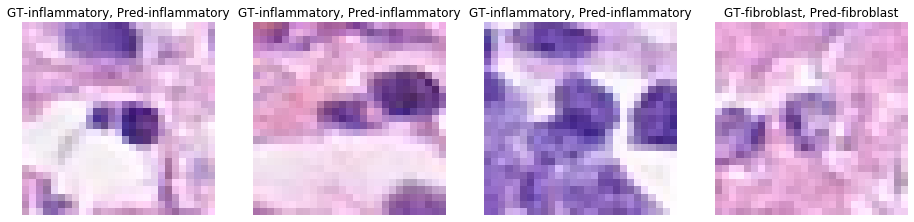

In [125]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Mock 2nd Model (leNet)
Based on week 10 QnA (week 10 lab uses VGG)

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 4 classes.
Found 198 validated image filenames belonging to 4 classes.


In [127]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [128]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet.fit(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)

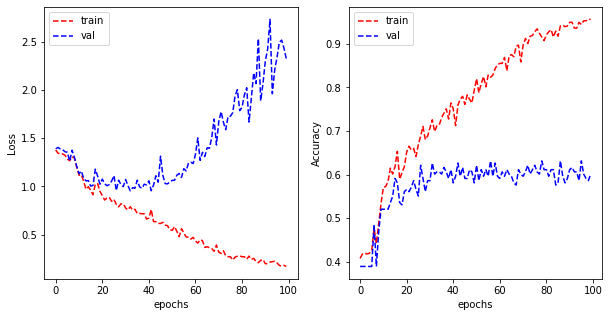

In [129]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Data Augmentation/Tuning for leNet model
TODO

# Mock 3rd Model (VGG)
Based on week 10 lab

In [130]:
import tensorflow as tf

OUTPUT_CLASSES = 4
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [131]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [132]:
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

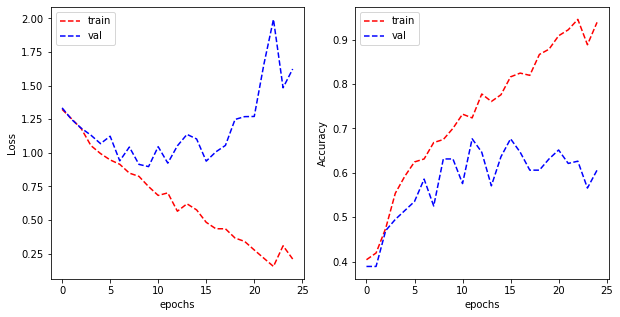

In [133]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Data Augmentation/Tuning for VGG model
TODO

# Model Development part 2
Our assignment has 2 parts:
- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous).
- Classify images according to cell-type, such as: fibroblast,inflammatory,epithelial or others.

Now I'll do the detecting cancerous cell of the assignment

### EDA

In [170]:
train_data.cellTypeName.unique()

array(['epithelial', 'fibroblast', 'inflammatory', 'others'], dtype=object)

Since there is 4 cell type and 2 isCancerous type, the number of label that one model has to predict is 8. It is better to have 4 models and each model handling 1 cell type and 2 isCancerous type and predict 2 label than having one model predict 8. 

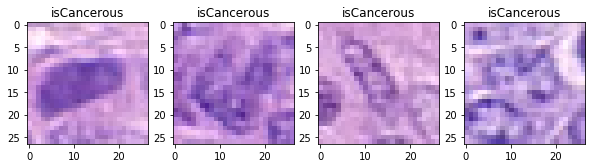

In [171]:
from PIL import Image

label_names = {'isCancerous' : 1, 'notCancerous' : 0}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['isCancerous']
target_list = list(target)

fig = plt.figure(figsize=[10,10])
n = 4
for i in np.arange(n):
    plt.subplot(1, n, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

An interesting revalation occur, apparently cell type fibroblast, inflammatory and other does not have isCancerous lable while cell type epithelial does not have notCancerous label. 

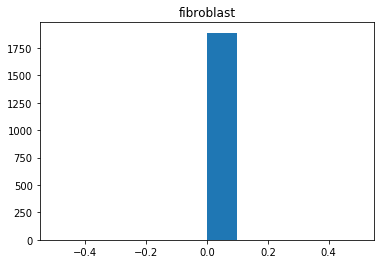

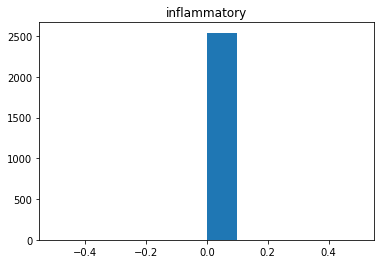

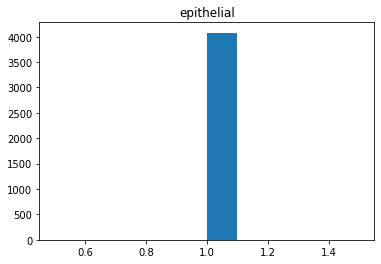

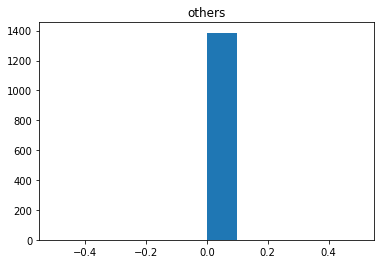

In [172]:

fibroblast = data[data['cellType']==0]
inflammatory = data[data['cellType']==1]
epithelial = data[data['cellType']==2]
others = data[data['cellType']==3]


plt.hist(fibroblast['isCancerous'])
plt.title('fibroblast')
plt.show()

plt.hist(inflammatory['isCancerous'])
plt.title('inflammatory')
plt.show()

plt.hist(epithelial['isCancerous'])
plt.title('epithelial')
plt.show()

plt.hist(others['isCancerous'])
plt.title('others')
plt.show()

From the observation above, it would not be smart to have 4 models handling each type of cell. Sorry if this contracdict with what I said above but I tried to avoid a "Zero Frequency Probem"

In [173]:
"""
train_data_fibroblast = train_data[train_data['cellType']=='0']
train_data_inflammatory = train_data[train_data['cellType']=='1']
train_data_epithelial = train_data[train_data['cellType']=='2']
train_data_others = train_data[train_data['cellType']=='3']

test_data_fibroblast = test_data[test_data['cellType']=='0']
test_data_inflammatory = test_data[test_data['cellType']=='1']
test_data_epithelial = test_data[test_data['cellType']=='2']
test_data_others = test_data[test_data['cellType']=='3']

val_data_fibroblast = val_data[val_data['cellType']=='0']
val_data_inflammatory = val_data[val_data['cellType']=='1']
val_data_epithelial = val_data[val_data['cellType']=='2']
val_data_others = val_data[val_data['cellType']=='3']
"""

"\ntrain_data_fibroblast = train_data[train_data['cellType']=='0']\ntrain_data_inflammatory = train_data[train_data['cellType']=='1']\ntrain_data_epithelial = train_data[train_data['cellType']=='2']\ntrain_data_others = train_data[train_data['cellType']=='3']\n\ntest_data_fibroblast = test_data[test_data['cellType']=='0']\ntest_data_inflammatory = test_data[test_data['cellType']=='1']\ntest_data_epithelial = test_data[test_data['cellType']=='2']\ntest_data_others = test_data[test_data['cellType']=='3']\n\nval_data_fibroblast = val_data[val_data['cellType']=='0']\nval_data_inflammatory = val_data[val_data['cellType']=='1']\nval_data_epithelial = val_data[val_data['cellType']=='2']\nval_data_others = val_data[val_data['cellType']=='3']\n"

### Training the model

In [174]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [175]:
model_cancer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])


In [176]:
model_cancer.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [177]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [189]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [179]:
history = model_cancer.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

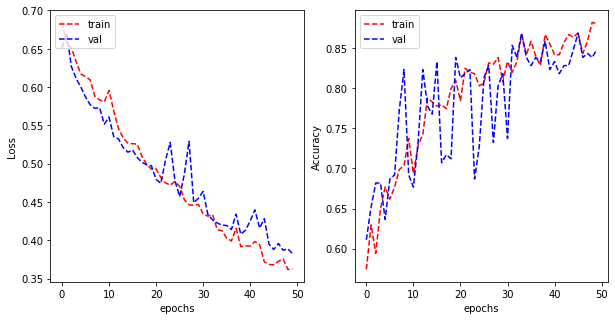

In [180]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [181]:
reg_lambda = 0.02

model_cancer_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [182]:
model_cancer_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [183]:
history_cancer_reg = model_cancer_reg.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

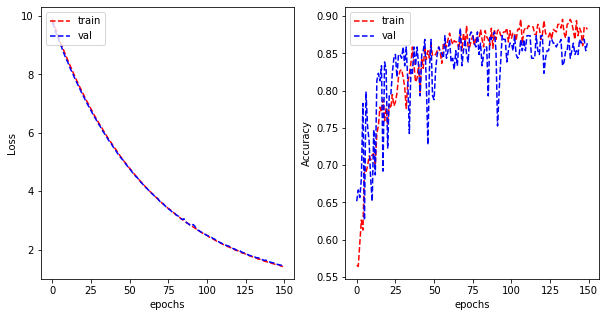

In [184]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cancer_reg.history['loss'], 'r--')
plt.plot(history_cancer_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cancer_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_cancer_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Drop out

In [185]:
reg_lambda = 0.02

model_cancer_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [186]:
model_cancer_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [187]:
history_cancer_drop = model_cancer_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

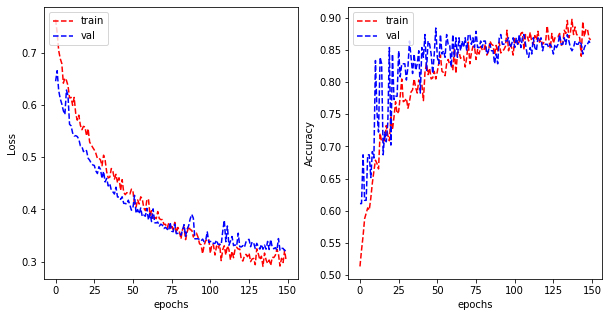

In [188]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cancer_drop.history['loss'], 'r--')
plt.plot(history_cancer_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cancer_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_cancer_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Cross validation to train the model

In [163]:
from sklearn.model_selection import KFold, StratifiedKFold

In [270]:
Y = train_data[['isCancerous']]
kf = KFold(n_splits = 10)
Y

,isCancerous
7873,1
2790,1
1828,1
2370,1
6048,0
...,...
4491,0
9667,0
140,0
6924,0


In [271]:
idg = ImageDataGenerator(rescale=1./255, data_format='channels_last')

In [272]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [273]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/cancer_CV/'
fold_var = 1
reg_lambda = 0.02
for train_index, val_index in kf.split(Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
    train_datagen = idg.flow_from_dataframe(dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
    valid_datagen  = idg.flow_from_dataframe(dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
       


    # CREATE NEW MODEL
    model_cancer_CV = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
    # COMPILE NEW MODEL
    model_cancer_CV.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history_CV = model_cancer_CV.fit(train_datagen,
                epochs=125,
                callbacks=callbacks_list,
                validation_data= valid_datagen,
                verbose=1)
    #PLOT HISTORY
    #       :
    #       :

    # LOAD BEST MODEL to evaluate the performance of the model
   
    model_cancer_CV.load_weights("/cancer_CV/model_"+str(fold_var)+".h5")

    results = model_cancer_CV.evaluate(valid_datagen)
    results = dict(zip(model_cancer_CV.metrics_names,results))

    VALIDATION_ACCURACY.append(results['categorical_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1



Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.
Epoch 1/125
19/19 [==============================] - 1s 24ms/step - loss: 9.8949 - categorical_accuracy: 0.5640 - val_loss: 9.7711 - val_categorical_accuracy: 0.6111
Epoch 2/125
19/19 [==============================] - 0s 18ms/step - loss: 9.7277 - categorical_accuracy: 0.5842 - val_loss: 9.6196 - val_categorical_accuracy: 0.6111
Epoch 3/125
19/19 [==============================] - 0s 19ms/step - loss: 9.5771 - categorical_accuracy: 0.5859 - val_loss: 9.4907 - val_categorical_accuracy: 0.7071
Epoch 4/125
19/19 [==============================] - 0s 18ms/step - loss: 9.4265 - categorical_accuracy: 0.6229 - val_loss: 9.3291 - val_categorical_accuracy: 0.6111
Epoch 5/125
19/19 [==============================] - 0s 19ms/step - loss: 9.2751 - categorical_accuracy: 0.6431 - val_loss: 9.1859 - val_categorical_accuracy: 0.6212
Epoch 6/125
19/19 [==============================]

19/19 [==============================] - 0s 19ms/step - loss: 6.1587 - categorical_accuracy: 0.8148 - val_loss: 6.1399 - val_categorical_accuracy: 0.8232
Epoch 34/125
19/19 [==============================] - 0s 19ms/step - loss: 6.0683 - categorical_accuracy: 0.8182 - val_loss: 6.0304 - val_categorical_accuracy: 0.8485
Epoch 35/125
19/19 [==============================] - 0s 18ms/step - loss: 5.9851 - categorical_accuracy: 0.8215 - val_loss: 5.9473 - val_categorical_accuracy: 0.8485
Epoch 36/125
19/19 [==============================] - 0s 20ms/step - loss: 5.9075 - categorical_accuracy: 0.8148 - val_loss: 5.8581 - val_categorical_accuracy: 0.8081
Epoch 37/125
19/19 [==============================] - 0s 18ms/step - loss: 5.8209 - categorical_accuracy: 0.8266 - val_loss: 5.7856 - val_categorical_accuracy: 0.8384
Epoch 38/125
19/19 [==============================] - 0s 18ms/step - loss: 5.7304 - categorical_accuracy: 0.8350 - val_loss: 5.6938 - val_categorical_accuracy: 0.8434
Epoch 39/12

Epoch 66/125
19/19 [==============================] - 0s 19ms/step - loss: 3.8916 - categorical_accuracy: 0.8771 - val_loss: 3.8787 - val_categorical_accuracy: 0.8737
Epoch 67/125
19/19 [==============================] - 0s 18ms/step - loss: 3.8389 - categorical_accuracy: 0.8636 - val_loss: 3.8273 - val_categorical_accuracy: 0.8636
Epoch 68/125
19/19 [==============================] - 0s 23ms/step - loss: 3.7903 - categorical_accuracy: 0.8636 - val_loss: 3.7770 - val_categorical_accuracy: 0.8737
Epoch 69/125
19/19 [==============================] - 0s 21ms/step - loss: 3.7406 - categorical_accuracy: 0.8485 - val_loss: 3.7676 - val_categorical_accuracy: 0.7980
Epoch 70/125
19/19 [==============================] - 0s 19ms/step - loss: 3.6882 - categorical_accuracy: 0.8754 - val_loss: 3.6802 - val_categorical_accuracy: 0.8586
Epoch 71/125
19/19 [==============================] - 0s 21ms/step - loss: 3.6373 - categorical_accuracy: 0.8704 - val_loss: 3.6397 - val_categorical_accuracy: 0.838

Epoch 99/125
19/19 [==============================] - 0s 18ms/step - loss: 2.5350 - categorical_accuracy: 0.8805 - val_loss: 2.5580 - val_categorical_accuracy: 0.8485
Epoch 100/125
19/19 [==============================] - 0s 17ms/step - loss: 2.5046 - categorical_accuracy: 0.8805 - val_loss: 2.5121 - val_categorical_accuracy: 0.8687
Epoch 101/125
19/19 [==============================] - 0s 16ms/step - loss: 2.4765 - categorical_accuracy: 0.8805 - val_loss: 2.5409 - val_categorical_accuracy: 0.7677
Epoch 102/125
19/19 [==============================] - 0s 17ms/step - loss: 2.4431 - categorical_accuracy: 0.8636 - val_loss: 2.4950 - val_categorical_accuracy: 0.8081
Epoch 103/125
19/19 [==============================] - 0s 17ms/step - loss: 2.4248 - categorical_accuracy: 0.8737 - val_loss: 2.4206 - val_categorical_accuracy: 0.8687
Epoch 104/125
19/19 [==============================] - 0s 16ms/step - loss: 2.3847 - categorical_accuracy: 0.8838 - val_loss: 2.3920 - val_categorical_accuracy: 

Epoch 6/125
19/19 [==============================] - 0s 17ms/step - loss: 9.1142 - categorical_accuracy: 0.6549 - val_loss: 9.0267 - val_categorical_accuracy: 0.7020
Epoch 7/125
19/19 [==============================] - 0s 18ms/step - loss: 8.9800 - categorical_accuracy: 0.6852 - val_loss: 8.8987 - val_categorical_accuracy: 0.6162
Epoch 8/125
19/19 [==============================] - 0s 18ms/step - loss: 8.8549 - categorical_accuracy: 0.6616 - val_loss: 8.8028 - val_categorical_accuracy: 0.6818
Epoch 9/125
19/19 [==============================] - 0s 17ms/step - loss: 8.7132 - categorical_accuracy: 0.6953 - val_loss: 8.6434 - val_categorical_accuracy: 0.8081
Epoch 10/125
19/19 [==============================] - 0s 17ms/step - loss: 8.5758 - categorical_accuracy: 0.7273 - val_loss: 8.5020 - val_categorical_accuracy: 0.7828
Epoch 11/125
19/19 [==============================] - 0s 17ms/step - loss: 8.4537 - categorical_accuracy: 0.7020 - val_loss: 8.3778 - val_categorical_accuracy: 0.6818
Ep

Epoch 39/125
19/19 [==============================] - 0s 18ms/step - loss: 5.6389 - categorical_accuracy: 0.8333 - val_loss: 5.5988 - val_categorical_accuracy: 0.7980
Epoch 40/125
19/19 [==============================] - 0s 18ms/step - loss: 5.5592 - categorical_accuracy: 0.8350 - val_loss: 5.5262 - val_categorical_accuracy: 0.8434
Epoch 41/125
19/19 [==============================] - 0s 17ms/step - loss: 5.4778 - categorical_accuracy: 0.8367 - val_loss: 5.4445 - val_categorical_accuracy: 0.8535
Epoch 42/125
19/19 [==============================] - 0s 17ms/step - loss: 5.4016 - categorical_accuracy: 0.8401 - val_loss: 5.3662 - val_categorical_accuracy: 0.8283
Epoch 43/125
19/19 [==============================] - 0s 18ms/step - loss: 5.3415 - categorical_accuracy: 0.8215 - val_loss: 5.3127 - val_categorical_accuracy: 0.8485
Epoch 44/125
19/19 [==============================] - 0s 17ms/step - loss: 5.2548 - categorical_accuracy: 0.8519 - val_loss: 5.2187 - val_categorical_accuracy: 0.828

Epoch 72/125
19/19 [==============================] - 0s 18ms/step - loss: 3.5835 - categorical_accuracy: 0.8721 - val_loss: 3.5703 - val_categorical_accuracy: 0.8687
Epoch 73/125
19/19 [==============================] - 0s 18ms/step - loss: 3.5376 - categorical_accuracy: 0.8721 - val_loss: 3.5334 - val_categorical_accuracy: 0.8232
Epoch 74/125
19/19 [==============================] - 0s 18ms/step - loss: 3.4981 - categorical_accuracy: 0.8502 - val_loss: 3.4795 - val_categorical_accuracy: 0.8687
Epoch 75/125
19/19 [==============================] - 0s 17ms/step - loss: 3.4412 - categorical_accuracy: 0.8636 - val_loss: 3.4341 - val_categorical_accuracy: 0.8535
Epoch 76/125
19/19 [==============================] - 0s 17ms/step - loss: 3.3953 - categorical_accuracy: 0.8805 - val_loss: 3.4084 - val_categorical_accuracy: 0.8586
Epoch 77/125
19/19 [==============================] - 0s 18ms/step - loss: 3.3509 - categorical_accuracy: 0.8805 - val_loss: 3.3606 - val_categorical_accuracy: 0.818

Epoch 105/125
19/19 [==============================] - 0s 17ms/step - loss: 2.3465 - categorical_accuracy: 0.8737 - val_loss: 2.4206 - val_categorical_accuracy: 0.7879
Epoch 106/125
19/19 [==============================] - 0s 17ms/step - loss: 2.3308 - categorical_accuracy: 0.8603 - val_loss: 2.3283 - val_categorical_accuracy: 0.8535
Epoch 107/125
19/19 [==============================] - 0s 17ms/step - loss: 2.2912 - categorical_accuracy: 0.8872 - val_loss: 2.3117 - val_categorical_accuracy: 0.8384
Epoch 108/125
19/19 [==============================] - 0s 17ms/step - loss: 2.2725 - categorical_accuracy: 0.8771 - val_loss: 2.2869 - val_categorical_accuracy: 0.8485
Epoch 109/125
19/19 [==============================] - 0s 17ms/step - loss: 2.2331 - categorical_accuracy: 0.8872 - val_loss: 2.2653 - val_categorical_accuracy: 0.8485
Epoch 110/125
19/19 [==============================] - 0s 16ms/step - loss: 2.2073 - categorical_accuracy: 0.8973 - val_loss: 2.2205 - val_categorical_accuracy:

Epoch 12/125
19/19 [==============================] - 0s 17ms/step - loss: 8.3659 - categorical_accuracy: 0.7626 - val_loss: 8.2924 - val_categorical_accuracy: 0.6869
Epoch 13/125
19/19 [==============================] - 0s 17ms/step - loss: 8.2438 - categorical_accuracy: 0.7189 - val_loss: 8.1710 - val_categorical_accuracy: 0.7020
Epoch 14/125
19/19 [==============================] - 0s 20ms/step - loss: 8.1274 - categorical_accuracy: 0.7407 - val_loss: 8.0567 - val_categorical_accuracy: 0.7929
Epoch 15/125
19/19 [==============================] - 0s 17ms/step - loss: 8.0063 - categorical_accuracy: 0.7407 - val_loss: 7.9484 - val_categorical_accuracy: 0.8182
Epoch 16/125
19/19 [==============================] - 0s 17ms/step - loss: 7.8845 - categorical_accuracy: 0.7525 - val_loss: 7.8214 - val_categorical_accuracy: 0.7727
Epoch 17/125
19/19 [==============================] - 0s 18ms/step - loss: 7.7682 - categorical_accuracy: 0.7727 - val_loss: 7.7181 - val_categorical_accuracy: 0.823

Epoch 45/125
19/19 [==============================] - 0s 17ms/step - loss: 5.1948 - categorical_accuracy: 0.8636 - val_loss: 5.2230 - val_categorical_accuracy: 0.7071
Epoch 46/125
19/19 [==============================] - 0s 17ms/step - loss: 5.1343 - categorical_accuracy: 0.8502 - val_loss: 5.1392 - val_categorical_accuracy: 0.7172
Epoch 47/125
19/19 [==============================] - 0s 17ms/step - loss: 5.0580 - categorical_accuracy: 0.8350 - val_loss: 5.0336 - val_categorical_accuracy: 0.8636
Epoch 48/125
19/19 [==============================] - 0s 17ms/step - loss: 4.9913 - categorical_accuracy: 0.8485 - val_loss: 4.9637 - val_categorical_accuracy: 0.8182
Epoch 49/125
19/19 [==============================] - 0s 19ms/step - loss: 4.9186 - categorical_accuracy: 0.8603 - val_loss: 4.8934 - val_categorical_accuracy: 0.8636
Epoch 50/125
19/19 [==============================] - 0s 17ms/step - loss: 4.8479 - categorical_accuracy: 0.8434 - val_loss: 4.8264 - val_categorical_accuracy: 0.873

Epoch 78/125
19/19 [==============================] - 0s 17ms/step - loss: 3.3286 - categorical_accuracy: 0.8670 - val_loss: 3.3340 - val_categorical_accuracy: 0.8333
Epoch 79/125
19/19 [==============================] - 0s 17ms/step - loss: 3.2778 - categorical_accuracy: 0.8687 - val_loss: 3.2845 - val_categorical_accuracy: 0.8384
Epoch 80/125
19/19 [==============================] - 0s 17ms/step - loss: 3.2360 - categorical_accuracy: 0.8721 - val_loss: 3.2346 - val_categorical_accuracy: 0.8586
Epoch 81/125
19/19 [==============================] - 0s 17ms/step - loss: 3.1919 - categorical_accuracy: 0.8653 - val_loss: 3.1920 - val_categorical_accuracy: 0.8586
Epoch 82/125
19/19 [==============================] - 0s 17ms/step - loss: 3.1517 - categorical_accuracy: 0.8754 - val_loss: 3.1526 - val_categorical_accuracy: 0.8586
Epoch 83/125
19/19 [==============================] - 0s 17ms/step - loss: 3.1104 - categorical_accuracy: 0.8771 - val_loss: 3.1142 - val_categorical_accuracy: 0.843

19/19 [==============================] - 0s 19ms/step - loss: 2.2246 - categorical_accuracy: 0.8788 - val_loss: 2.2341 - val_categorical_accuracy: 0.8687
Epoch 111/125
19/19 [==============================] - 0s 18ms/step - loss: 2.1908 - categorical_accuracy: 0.8805 - val_loss: 2.2202 - val_categorical_accuracy: 0.8333
Epoch 112/125
19/19 [==============================] - 0s 16ms/step - loss: 2.1779 - categorical_accuracy: 0.8771 - val_loss: 2.1940 - val_categorical_accuracy: 0.8434
Epoch 113/125
19/19 [==============================] - 0s 17ms/step - loss: 2.1488 - categorical_accuracy: 0.8704 - val_loss: 2.1537 - val_categorical_accuracy: 0.8535
Epoch 114/125
19/19 [==============================] - 0s 19ms/step - loss: 2.1140 - categorical_accuracy: 0.8889 - val_loss: 2.1275 - val_categorical_accuracy: 0.8687
Epoch 115/125
19/19 [==============================] - 0s 18ms/step - loss: 2.0875 - categorical_accuracy: 0.8805 - val_loss: 2.1038 - val_categorical_accuracy: 0.8586
Epoch 

Epoch 17/125
19/19 [==============================] - 0s 19ms/step - loss: 7.7512 - categorical_accuracy: 0.7256 - val_loss: 7.6859 - val_categorical_accuracy: 0.8030
Epoch 18/125
19/19 [==============================] - 0s 19ms/step - loss: 7.6306 - categorical_accuracy: 0.7609 - val_loss: 7.5747 - val_categorical_accuracy: 0.8030
Epoch 19/125
19/19 [==============================] - 0s 17ms/step - loss: 7.5166 - categorical_accuracy: 0.7710 - val_loss: 7.4738 - val_categorical_accuracy: 0.8333
Epoch 20/125
19/19 [==============================] - 0s 18ms/step - loss: 7.4142 - categorical_accuracy: 0.7946 - val_loss: 7.3554 - val_categorical_accuracy: 0.7273
Epoch 21/125
19/19 [==============================] - 0s 19ms/step - loss: 7.3037 - categorical_accuracy: 0.7912 - val_loss: 7.2519 - val_categorical_accuracy: 0.7222
Epoch 22/125
19/19 [==============================] - 0s 17ms/step - loss: 7.1990 - categorical_accuracy: 0.7896 - val_loss: 7.1560 - val_categorical_accuracy: 0.697

Epoch 50/125
19/19 [==============================] - 0s 17ms/step - loss: 4.8385 - categorical_accuracy: 0.8434 - val_loss: 4.8153 - val_categorical_accuracy: 0.8636
Epoch 51/125
19/19 [==============================] - 0s 17ms/step - loss: 4.7718 - categorical_accuracy: 0.8350 - val_loss: 4.7522 - val_categorical_accuracy: 0.8586
Epoch 52/125
19/19 [==============================] - 0s 17ms/step - loss: 4.6988 - categorical_accuracy: 0.8670 - val_loss: 4.6854 - val_categorical_accuracy: 0.8687
Epoch 53/125
19/19 [==============================] - 0s 18ms/step - loss: 4.6554 - categorical_accuracy: 0.8350 - val_loss: 4.6276 - val_categorical_accuracy: 0.8384
Epoch 54/125
19/19 [==============================] - 0s 17ms/step - loss: 4.5756 - categorical_accuracy: 0.8502 - val_loss: 4.5577 - val_categorical_accuracy: 0.8636
Epoch 55/125
19/19 [==============================] - 0s 18ms/step - loss: 4.5183 - categorical_accuracy: 0.8502 - val_loss: 4.4966 - val_categorical_accuracy: 0.853

Epoch 83/125
19/19 [==============================] - 0s 17ms/step - loss: 3.1068 - categorical_accuracy: 0.8771 - val_loss: 3.1046 - val_categorical_accuracy: 0.8838
Epoch 84/125
19/19 [==============================] - 0s 18ms/step - loss: 3.0632 - categorical_accuracy: 0.8771 - val_loss: 3.0655 - val_categorical_accuracy: 0.8687
Epoch 85/125
19/19 [==============================] - 0s 17ms/step - loss: 3.0244 - categorical_accuracy: 0.8704 - val_loss: 3.0333 - val_categorical_accuracy: 0.8384
Epoch 86/125
19/19 [==============================] - 0s 18ms/step - loss: 2.9913 - categorical_accuracy: 0.8653 - val_loss: 2.9912 - val_categorical_accuracy: 0.8586
Epoch 87/125
19/19 [==============================] - 0s 18ms/step - loss: 2.9474 - categorical_accuracy: 0.8687 - val_loss: 2.9554 - val_categorical_accuracy: 0.8434
Epoch 88/125
19/19 [==============================] - 0s 17ms/step - loss: 2.9139 - categorical_accuracy: 0.8670 - val_loss: 2.9170 - val_categorical_accuracy: 0.858

Epoch 116/125
19/19 [==============================] - 0s 17ms/step - loss: 2.0667 - categorical_accuracy: 0.8754 - val_loss: 2.0870 - val_categorical_accuracy: 0.8384
Epoch 117/125
19/19 [==============================] - 0s 16ms/step - loss: 2.0343 - categorical_accuracy: 0.8855 - val_loss: 2.0564 - val_categorical_accuracy: 0.8687
Epoch 118/125
19/19 [==============================] - 0s 17ms/step - loss: 2.0092 - categorical_accuracy: 0.8788 - val_loss: 2.0371 - val_categorical_accuracy: 0.8384
Epoch 119/125
19/19 [==============================] - 0s 17ms/step - loss: 1.9867 - categorical_accuracy: 0.8956 - val_loss: 2.0142 - val_categorical_accuracy: 0.8384
Epoch 120/125
19/19 [==============================] - 0s 16ms/step - loss: 1.9607 - categorical_accuracy: 0.8872 - val_loss: 1.9889 - val_categorical_accuracy: 0.8586
Epoch 121/125
19/19 [==============================] - 0s 17ms/step - loss: 1.9396 - categorical_accuracy: 0.8838 - val_loss: 2.0103 - val_categorical_accuracy:

Epoch 23/125
19/19 [==============================] - 0s 17ms/step - loss: 7.1003 - categorical_accuracy: 0.7946 - val_loss: 7.0393 - val_categorical_accuracy: 0.8384
Epoch 24/125
19/19 [==============================] - 0s 17ms/step - loss: 6.9955 - categorical_accuracy: 0.7879 - val_loss: 6.9395 - val_categorical_accuracy: 0.7374
Epoch 25/125
19/19 [==============================] - 0s 19ms/step - loss: 6.8876 - categorical_accuracy: 0.7795 - val_loss: 6.8588 - val_categorical_accuracy: 0.8283
Epoch 26/125
19/19 [==============================] - 0s 19ms/step - loss: 6.7861 - categorical_accuracy: 0.8199 - val_loss: 6.7989 - val_categorical_accuracy: 0.7172
Epoch 27/125
19/19 [==============================] - 0s 19ms/step - loss: 6.7093 - categorical_accuracy: 0.7912 - val_loss: 6.6451 - val_categorical_accuracy: 0.8535
Epoch 28/125
19/19 [==============================] - 0s 18ms/step - loss: 6.6023 - categorical_accuracy: 0.8098 - val_loss: 6.5686 - val_categorical_accuracy: 0.702

Epoch 56/125
19/19 [==============================] - 0s 18ms/step - loss: 4.4533 - categorical_accuracy: 0.8535 - val_loss: 4.4378 - val_categorical_accuracy: 0.8232
Epoch 57/125
19/19 [==============================] - 0s 17ms/step - loss: 4.3942 - categorical_accuracy: 0.8434 - val_loss: 4.3905 - val_categorical_accuracy: 0.8384
Epoch 58/125
19/19 [==============================] - 0s 17ms/step - loss: 4.3339 - categorical_accuracy: 0.8552 - val_loss: 4.3209 - val_categorical_accuracy: 0.8384
Epoch 59/125
19/19 [==============================] - 0s 17ms/step - loss: 4.2753 - categorical_accuracy: 0.8636 - val_loss: 4.2541 - val_categorical_accuracy: 0.8889
Epoch 60/125
19/19 [==============================] - 0s 17ms/step - loss: 4.2229 - categorical_accuracy: 0.8519 - val_loss: 4.2408 - val_categorical_accuracy: 0.7980
Epoch 61/125
19/19 [==============================] - 0s 17ms/step - loss: 4.1632 - categorical_accuracy: 0.8485 - val_loss: 4.1426 - val_categorical_accuracy: 0.873

Epoch 89/125
19/19 [==============================] - 0s 17ms/step - loss: 2.8688 - categorical_accuracy: 0.8872 - val_loss: 2.8733 - val_categorical_accuracy: 0.8788
Epoch 90/125
19/19 [==============================] - 0s 17ms/step - loss: 2.8326 - categorical_accuracy: 0.8855 - val_loss: 2.8375 - val_categorical_accuracy: 0.8687
Epoch 91/125
19/19 [==============================] - 0s 17ms/step - loss: 2.8016 - categorical_accuracy: 0.8855 - val_loss: 2.8072 - val_categorical_accuracy: 0.8535
Epoch 92/125
19/19 [==============================] - 0s 17ms/step - loss: 2.7569 - categorical_accuracy: 0.8822 - val_loss: 2.7852 - val_categorical_accuracy: 0.8182
Epoch 93/125
19/19 [==============================] - 0s 16ms/step - loss: 2.7282 - categorical_accuracy: 0.8838 - val_loss: 2.7387 - val_categorical_accuracy: 0.8485
Epoch 94/125
19/19 [==============================] - 0s 16ms/step - loss: 2.6966 - categorical_accuracy: 0.8822 - val_loss: 2.7000 - val_categorical_accuracy: 0.868

19/19 [==============================] - 0s 17ms/step - loss: 1.9481 - categorical_accuracy: 0.8721 - val_loss: 1.9642 - val_categorical_accuracy: 0.8687
Epoch 122/125
19/19 [==============================] - 0s 16ms/step - loss: 1.9225 - categorical_accuracy: 0.8721 - val_loss: 1.9362 - val_categorical_accuracy: 0.8636
Epoch 123/125
19/19 [==============================] - 0s 17ms/step - loss: 1.9012 - categorical_accuracy: 0.8704 - val_loss: 1.9249 - val_categorical_accuracy: 0.8485
Epoch 124/125
19/19 [==============================] - 0s 16ms/step - loss: 1.8848 - categorical_accuracy: 0.8653 - val_loss: 1.9136 - val_categorical_accuracy: 0.8283
Epoch 125/125
7/7 [==============================] - 0s 9ms/step - loss: 9.8535 - categorical_accuracy: 0.8485
Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.
Epoch 1/125
19/19 [==============================] - 1s 22ms/step - loss: 9.8798 - categorical_accuracy: 0.5404

Epoch 28/125
19/19 [==============================] - 0s 17ms/step - loss: 6.6187 - categorical_accuracy: 0.7997 - val_loss: 6.5667 - val_categorical_accuracy: 0.7727
Epoch 29/125
19/19 [==============================] - 0s 17ms/step - loss: 6.5188 - categorical_accuracy: 0.7997 - val_loss: 6.4744 - val_categorical_accuracy: 0.8535
Epoch 30/125
19/19 [==============================] - 0s 17ms/step - loss: 6.4301 - categorical_accuracy: 0.8232 - val_loss: 6.3812 - val_categorical_accuracy: 0.8535
Epoch 31/125
19/19 [==============================] - 0s 17ms/step - loss: 6.3414 - categorical_accuracy: 0.8232 - val_loss: 6.2951 - val_categorical_accuracy: 0.7677
Epoch 32/125
19/19 [==============================] - 0s 17ms/step - loss: 6.2471 - categorical_accuracy: 0.8114 - val_loss: 6.2021 - val_categorical_accuracy: 0.8586
Epoch 33/125
19/19 [==============================] - 0s 17ms/step - loss: 6.1557 - categorical_accuracy: 0.8316 - val_loss: 6.1217 - val_categorical_accuracy: 0.848

Epoch 61/125
19/19 [==============================] - 0s 17ms/step - loss: 4.1696 - categorical_accuracy: 0.8653 - val_loss: 4.1524 - val_categorical_accuracy: 0.8384
Epoch 62/125
19/19 [==============================] - 0s 17ms/step - loss: 4.1060 - categorical_accuracy: 0.8636 - val_loss: 4.0961 - val_categorical_accuracy: 0.8636
Epoch 63/125
19/19 [==============================] - 0s 17ms/step - loss: 4.0515 - categorical_accuracy: 0.8586 - val_loss: 4.0403 - val_categorical_accuracy: 0.8687
Epoch 64/125
19/19 [==============================] - 0s 17ms/step - loss: 4.0126 - categorical_accuracy: 0.8451 - val_loss: 3.9858 - val_categorical_accuracy: 0.8737
Epoch 65/125
19/19 [==============================] - 0s 16ms/step - loss: 3.9520 - categorical_accuracy: 0.8535 - val_loss: 3.9344 - val_categorical_accuracy: 0.8586
Epoch 66/125
19/19 [==============================] - 0s 16ms/step - loss: 3.8902 - categorical_accuracy: 0.8687 - val_loss: 3.8801 - val_categorical_accuracy: 0.883

Epoch 94/125
19/19 [==============================] - 0s 16ms/step - loss: 2.7019 - categorical_accuracy: 0.8754 - val_loss: 2.7045 - val_categorical_accuracy: 0.8586
Epoch 95/125
19/19 [==============================] - 0s 16ms/step - loss: 2.6640 - categorical_accuracy: 0.8838 - val_loss: 2.6726 - val_categorical_accuracy: 0.8636
Epoch 96/125
19/19 [==============================] - 0s 17ms/step - loss: 2.6367 - categorical_accuracy: 0.8855 - val_loss: 2.6381 - val_categorical_accuracy: 0.8586
Epoch 97/125
19/19 [==============================] - 0s 16ms/step - loss: 2.6020 - categorical_accuracy: 0.8754 - val_loss: 2.6103 - val_categorical_accuracy: 0.8535
Epoch 98/125
19/19 [==============================] - 0s 17ms/step - loss: 2.5635 - categorical_accuracy: 0.8855 - val_loss: 2.5793 - val_categorical_accuracy: 0.8485
Epoch 99/125
19/19 [==============================] - 0s 16ms/step - loss: 2.5373 - categorical_accuracy: 0.8771 - val_loss: 2.5477 - val_categorical_accuracy: 0.848

7/7 [==============================] - 0s 10ms/step - loss: 9.8780 - categorical_accuracy: 0.8434
Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.
Epoch 1/125
19/19 [==============================] - 1s 22ms/step - loss: 9.8840 - categorical_accuracy: 0.5455 - val_loss: 9.7684 - val_categorical_accuracy: 0.6111
Epoch 2/125
19/19 [==============================] - 0s 17ms/step - loss: 9.7064 - categorical_accuracy: 0.5808 - val_loss: 9.6123 - val_categorical_accuracy: 0.6111
Epoch 3/125
19/19 [==============================] - 0s 17ms/step - loss: 9.5547 - categorical_accuracy: 0.6313 - val_loss: 9.4710 - val_categorical_accuracy: 0.6566
Epoch 4/125
19/19 [==============================] - 0s 17ms/step - loss: 9.4127 - categorical_accuracy: 0.6246 - val_loss: 9.3299 - val_categorical_accuracy: 0.6111
Epoch 5/125
19/19 [==============================] - 0s 17ms/step - loss: 9.2787 - categorical_accuracy: 0.6330 - val_

Epoch 33/125
19/19 [==============================] - 0s 16ms/step - loss: 6.1663 - categorical_accuracy: 0.8064 - val_loss: 6.1227 - val_categorical_accuracy: 0.8535
Epoch 34/125
19/19 [==============================] - 0s 16ms/step - loss: 6.0868 - categorical_accuracy: 0.7795 - val_loss: 6.0316 - val_categorical_accuracy: 0.8081
Epoch 35/125
19/19 [==============================] - 0s 17ms/step - loss: 5.9924 - categorical_accuracy: 0.8148 - val_loss: 5.9521 - val_categorical_accuracy: 0.8485
Epoch 36/125
19/19 [==============================] - 0s 16ms/step - loss: 5.9106 - categorical_accuracy: 0.8367 - val_loss: 5.8636 - val_categorical_accuracy: 0.8081
Epoch 37/125
19/19 [==============================] - 0s 16ms/step - loss: 5.8302 - categorical_accuracy: 0.8199 - val_loss: 5.7870 - val_categorical_accuracy: 0.8434
Epoch 38/125
19/19 [==============================] - 0s 17ms/step - loss: 5.7452 - categorical_accuracy: 0.8199 - val_loss: 5.7220 - val_categorical_accuracy: 0.833

Epoch 66/125
19/19 [==============================] - 0s 17ms/step - loss: 3.8970 - categorical_accuracy: 0.8687 - val_loss: 3.8810 - val_categorical_accuracy: 0.8737
Epoch 67/125
19/19 [==============================] - 0s 16ms/step - loss: 3.8426 - categorical_accuracy: 0.8569 - val_loss: 3.8294 - val_categorical_accuracy: 0.8737
Epoch 68/125
19/19 [==============================] - 0s 17ms/step - loss: 3.7932 - categorical_accuracy: 0.8670 - val_loss: 3.7878 - val_categorical_accuracy: 0.8384
Epoch 69/125
19/19 [==============================] - 0s 17ms/step - loss: 3.7384 - categorical_accuracy: 0.8603 - val_loss: 3.7371 - val_categorical_accuracy: 0.8434
Epoch 70/125
19/19 [==============================] - 0s 17ms/step - loss: 3.6916 - categorical_accuracy: 0.8670 - val_loss: 3.6804 - val_categorical_accuracy: 0.8687
Epoch 71/125
19/19 [==============================] - 0s 17ms/step - loss: 3.6474 - categorical_accuracy: 0.8653 - val_loss: 3.6325 - val_categorical_accuracy: 0.868

Epoch 99/125
19/19 [==============================] - 0s 17ms/step - loss: 2.5414 - categorical_accuracy: 0.8636 - val_loss: 2.5497 - val_categorical_accuracy: 0.8434
Epoch 100/125
19/19 [==============================] - 0s 17ms/step - loss: 2.5039 - categorical_accuracy: 0.8838 - val_loss: 2.5112 - val_categorical_accuracy: 0.8586
Epoch 101/125
19/19 [==============================] - ETA: 0s - loss: 2.4768 - categorical_accuracy: 0.88 - 0s 17ms/step - loss: 2.4726 - categorical_accuracy: 0.8788 - val_loss: 2.4866 - val_categorical_accuracy: 0.8485
Epoch 102/125
19/19 [==============================] - 0s 17ms/step - loss: 2.4434 - categorical_accuracy: 0.8838 - val_loss: 2.4556 - val_categorical_accuracy: 0.8586
Epoch 103/125
19/19 [==============================] - 0s 17ms/step - loss: 2.4189 - categorical_accuracy: 0.8754 - val_loss: 2.4208 - val_categorical_accuracy: 0.8636
Epoch 104/125
19/19 [==============================] - 0s 16ms/step - loss: 2.3847 - categorical_accuracy: 

Epoch 6/125
19/19 [==============================] - 0s 17ms/step - loss: 9.1535 - categorical_accuracy: 0.6263 - val_loss: 9.0600 - val_categorical_accuracy: 0.6212
Epoch 7/125
19/19 [==============================] - 0s 16ms/step - loss: 9.0198 - categorical_accuracy: 0.6566 - val_loss: 8.9270 - val_categorical_accuracy: 0.6970
Epoch 8/125
19/19 [==============================] - 0s 17ms/step - loss: 8.8719 - categorical_accuracy: 0.7256 - val_loss: 8.8126 - val_categorical_accuracy: 0.8182
Epoch 9/125
19/19 [==============================] - 0s 16ms/step - loss: 8.7465 - categorical_accuracy: 0.7239 - val_loss: 8.6615 - val_categorical_accuracy: 0.6869
Epoch 10/125
19/19 [==============================] - 0s 16ms/step - loss: 8.6182 - categorical_accuracy: 0.6953 - val_loss: 8.5340 - val_categorical_accuracy: 0.6818
Epoch 11/125
19/19 [==============================] - 0s 17ms/step - loss: 8.4947 - categorical_accuracy: 0.6852 - val_loss: 8.4091 - val_categorical_accuracy: 0.7273
Ep

Epoch 39/125
19/19 [==============================] - 0s 17ms/step - loss: 5.6694 - categorical_accuracy: 0.7980 - val_loss: 5.6449 - val_categorical_accuracy: 0.8182
Epoch 40/125
19/19 [==============================] - 0s 16ms/step - loss: 5.5858 - categorical_accuracy: 0.8047 - val_loss: 5.5484 - val_categorical_accuracy: 0.8687
Epoch 41/125
19/19 [==============================] - 0s 16ms/step - loss: 5.5108 - categorical_accuracy: 0.8215 - val_loss: 5.4668 - val_categorical_accuracy: 0.8535
Epoch 42/125
19/19 [==============================] - 0s 17ms/step - loss: 5.4360 - categorical_accuracy: 0.8367 - val_loss: 5.3991 - val_categorical_accuracy: 0.8485
Epoch 43/125
19/19 [==============================] - 0s 16ms/step - loss: 5.3558 - categorical_accuracy: 0.8367 - val_loss: 5.3435 - val_categorical_accuracy: 0.8333
Epoch 44/125
19/19 [==============================] - 0s 16ms/step - loss: 5.2760 - categorical_accuracy: 0.8418 - val_loss: 5.2434 - val_categorical_accuracy: 0.868

Epoch 72/125
19/19 [==============================] - 0s 17ms/step - loss: 3.5967 - categorical_accuracy: 0.8586 - val_loss: 3.5922 - val_categorical_accuracy: 0.8434
Epoch 73/125
19/19 [==============================] - 0s 17ms/step - loss: 3.5536 - categorical_accuracy: 0.8653 - val_loss: 3.5384 - val_categorical_accuracy: 0.8737
Epoch 74/125
19/19 [==============================] - 0s 16ms/step - loss: 3.5033 - categorical_accuracy: 0.8636 - val_loss: 3.5011 - val_categorical_accuracy: 0.8384
Epoch 75/125
19/19 [==============================] - 0s 17ms/step - loss: 3.4523 - categorical_accuracy: 0.8687 - val_loss: 3.4595 - val_categorical_accuracy: 0.8384
Epoch 76/125
19/19 [==============================] - 0s 16ms/step - loss: 3.4070 - categorical_accuracy: 0.8586 - val_loss: 3.4021 - val_categorical_accuracy: 0.8737
Epoch 77/125
19/19 [==============================] - 0s 16ms/step - loss: 3.3710 - categorical_accuracy: 0.8636 - val_loss: 3.3962 - val_categorical_accuracy: 0.823

19/19 [==============================] - 0s 16ms/step - loss: 2.3901 - categorical_accuracy: 0.8754 - val_loss: 2.3967 - val_categorical_accuracy: 0.8586
Epoch 105/125
19/19 [==============================] - 0s 17ms/step - loss: 2.3582 - categorical_accuracy: 0.8737 - val_loss: 2.3979 - val_categorical_accuracy: 0.8333
Epoch 106/125
19/19 [==============================] - 0s 16ms/step - loss: 2.3340 - categorical_accuracy: 0.8771 - val_loss: 2.3479 - val_categorical_accuracy: 0.8434
Epoch 107/125
19/19 [==============================] - 0s 16ms/step - loss: 2.3004 - categorical_accuracy: 0.8838 - val_loss: 2.3083 - val_categorical_accuracy: 0.8687
Epoch 108/125
19/19 [==============================] - 0s 16ms/step - loss: 2.2774 - categorical_accuracy: 0.8822 - val_loss: 2.2811 - val_categorical_accuracy: 0.8737
Epoch 109/125
19/19 [==============================] - 0s 16ms/step - loss: 2.2507 - categorical_accuracy: 0.8838 - val_loss: 2.2542 - val_categorical_accuracy: 0.8687
Epoch 

19/19 [==============================] - 0s 16ms/step - loss: 8.6044 - categorical_accuracy: 0.6902 - val_loss: 8.5243 - val_categorical_accuracy: 0.6566
Epoch 11/125
19/19 [==============================] - 0s 17ms/step - loss: 8.4751 - categorical_accuracy: 0.7222 - val_loss: 8.3969 - val_categorical_accuracy: 0.6818
Epoch 12/125
19/19 [==============================] - 0s 17ms/step - loss: 8.3511 - categorical_accuracy: 0.7256 - val_loss: 8.2882 - val_categorical_accuracy: 0.6414
Epoch 13/125
19/19 [==============================] - 0s 16ms/step - loss: 8.2400 - categorical_accuracy: 0.7003 - val_loss: 8.1556 - val_categorical_accuracy: 0.6818
Epoch 14/125
19/19 [==============================] - 0s 16ms/step - loss: 8.1080 - categorical_accuracy: 0.7357 - val_loss: 8.0587 - val_categorical_accuracy: 0.8232
Epoch 15/125
19/19 [==============================] - 0s 17ms/step - loss: 7.9917 - categorical_accuracy: 0.7559 - val_loss: 7.9290 - val_categorical_accuracy: 0.6768
Epoch 16/12

Epoch 43/125
19/19 [==============================] - 0s 17ms/step - loss: 5.3407 - categorical_accuracy: 0.8485 - val_loss: 5.3164 - val_categorical_accuracy: 0.8535
Epoch 44/125
19/19 [==============================] - 0s 16ms/step - loss: 5.2654 - categorical_accuracy: 0.8434 - val_loss: 5.2447 - val_categorical_accuracy: 0.7778
Epoch 45/125
19/19 [==============================] - 0s 16ms/step - loss: 5.1903 - categorical_accuracy: 0.8434 - val_loss: 5.1627 - val_categorical_accuracy: 0.8737
Epoch 46/125
19/19 [==============================] - 0s 17ms/step - loss: 5.1254 - categorical_accuracy: 0.8401 - val_loss: 5.1027 - val_categorical_accuracy: 0.8384
Epoch 47/125
19/19 [==============================] - 0s 17ms/step - loss: 5.0526 - categorical_accuracy: 0.8636 - val_loss: 5.0668 - val_categorical_accuracy: 0.7020
Epoch 48/125
19/19 [==============================] - 0s 16ms/step - loss: 4.9828 - categorical_accuracy: 0.8350 - val_loss: 4.9715 - val_categorical_accuracy: 0.833

Epoch 76/125
19/19 [==============================] - 0s 17ms/step - loss: 3.4171 - categorical_accuracy: 0.8670 - val_loss: 3.4046 - val_categorical_accuracy: 0.8434
Epoch 77/125
19/19 [==============================] - 0s 17ms/step - loss: 3.3601 - categorical_accuracy: 0.8704 - val_loss: 3.3541 - val_categorical_accuracy: 0.8788
Epoch 78/125
19/19 [==============================] - 0s 16ms/step - loss: 3.3155 - categorical_accuracy: 0.8855 - val_loss: 3.3162 - val_categorical_accuracy: 0.8485
Epoch 79/125
19/19 [==============================] - 0s 16ms/step - loss: 3.2730 - categorical_accuracy: 0.8771 - val_loss: 3.2705 - val_categorical_accuracy: 0.8636
Epoch 80/125
19/19 [==============================] - 0s 16ms/step - loss: 3.2266 - categorical_accuracy: 0.8737 - val_loss: 3.2293 - val_categorical_accuracy: 0.8535
Epoch 81/125
19/19 [==============================] - 0s 16ms/step - loss: 3.1902 - categorical_accuracy: 0.8822 - val_loss: 3.1851 - val_categorical_accuracy: 0.878

Epoch 109/125
19/19 [==============================] - 0s 16ms/step - loss: 2.2450 - categorical_accuracy: 0.8771 - val_loss: 2.2680 - val_categorical_accuracy: 0.8434
Epoch 110/125
19/19 [==============================] - 0s 16ms/step - loss: 2.2142 - categorical_accuracy: 0.8822 - val_loss: 2.2252 - val_categorical_accuracy: 0.8788
Epoch 111/125
19/19 [==============================] - 0s 16ms/step - loss: 2.1907 - categorical_accuracy: 0.8788 - val_loss: 2.2045 - val_categorical_accuracy: 0.8586
Epoch 112/125
19/19 [==============================] - 0s 16ms/step - loss: 2.1588 - categorical_accuracy: 0.8771 - val_loss: 2.2069 - val_categorical_accuracy: 0.8333
Epoch 113/125
19/19 [==============================] - 0s 17ms/step - loss: 2.1392 - categorical_accuracy: 0.8872 - val_loss: 2.1565 - val_categorical_accuracy: 0.8434
Epoch 114/125
19/19 [==============================] - 0s 16ms/step - loss: 2.1106 - categorical_accuracy: 0.8805 - val_loss: 2.1236 - val_categorical_accuracy:

Epoch 16/125
19/19 [==============================] - 0s 16ms/step - loss: 7.8660 - categorical_accuracy: 0.7643 - val_loss: 7.8154 - val_categorical_accuracy: 0.8182
Epoch 17/125
19/19 [==============================] - 0s 16ms/step - loss: 7.7581 - categorical_accuracy: 0.7407 - val_loss: 7.7186 - val_categorical_accuracy: 0.7626
Epoch 18/125
19/19 [==============================] - 0s 16ms/step - loss: 7.6475 - categorical_accuracy: 0.7593 - val_loss: 7.5794 - val_categorical_accuracy: 0.8232
Epoch 19/125
19/19 [==============================] - 0s 16ms/step - loss: 7.5360 - categorical_accuracy: 0.7492 - val_loss: 7.4810 - val_categorical_accuracy: 0.6818
Epoch 20/125
19/19 [==============================] - 0s 17ms/step - loss: 7.4250 - categorical_accuracy: 0.7626 - val_loss: 7.3776 - val_categorical_accuracy: 0.6818
Epoch 21/125
19/19 [==============================] - 0s 16ms/step - loss: 7.3163 - categorical_accuracy: 0.7508 - val_loss: 7.2527 - val_categorical_accuracy: 0.818

Epoch 49/125
19/19 [==============================] - 0s 16ms/step - loss: 4.9094 - categorical_accuracy: 0.8434 - val_loss: 4.8996 - val_categorical_accuracy: 0.8333
Epoch 50/125
19/19 [==============================] - 0s 16ms/step - loss: 4.8452 - categorical_accuracy: 0.8367 - val_loss: 4.8454 - val_categorical_accuracy: 0.8333
Epoch 51/125
19/19 [==============================] - 0s 16ms/step - loss: 4.7841 - categorical_accuracy: 0.8300 - val_loss: 4.7732 - val_categorical_accuracy: 0.8384
Epoch 52/125
19/19 [==============================] - 0s 16ms/step - loss: 4.7095 - categorical_accuracy: 0.8519 - val_loss: 4.6830 - val_categorical_accuracy: 0.8535
Epoch 53/125
19/19 [==============================] - 0s 16ms/step - loss: 4.6462 - categorical_accuracy: 0.8434 - val_loss: 4.6214 - val_categorical_accuracy: 0.8788
Epoch 54/125
19/19 [==============================] - 0s 16ms/step - loss: 4.5788 - categorical_accuracy: 0.8333 - val_loss: 4.6073 - val_categorical_accuracy: 0.782

Epoch 82/125
19/19 [==============================] - 0s 16ms/step - loss: 3.1565 - categorical_accuracy: 0.8552 - val_loss: 3.1698 - val_categorical_accuracy: 0.8333
Epoch 83/125
19/19 [==============================] - 0s 16ms/step - loss: 3.1063 - categorical_accuracy: 0.8670 - val_loss: 3.1017 - val_categorical_accuracy: 0.8838
Epoch 84/125
19/19 [==============================] - 0s 16ms/step - loss: 3.0701 - categorical_accuracy: 0.8620 - val_loss: 3.0893 - val_categorical_accuracy: 0.8384
Epoch 85/125
19/19 [==============================] - 0s 16ms/step - loss: 3.0291 - categorical_accuracy: 0.8704 - val_loss: 3.0249 - val_categorical_accuracy: 0.8586
Epoch 86/125
19/19 [==============================] - 0s 16ms/step - loss: 2.9876 - categorical_accuracy: 0.8653 - val_loss: 2.9852 - val_categorical_accuracy: 0.8737
Epoch 87/125
19/19 [==============================] - 0s 16ms/step - loss: 2.9471 - categorical_accuracy: 0.8889 - val_loss: 2.9532 - val_categorical_accuracy: 0.848

Epoch 115/125
19/19 [==============================] - 0s 16ms/step - loss: 2.0845 - categorical_accuracy: 0.8822 - val_loss: 2.0976 - val_categorical_accuracy: 0.8687
Epoch 116/125
19/19 [==============================] - 0s 16ms/step - loss: 2.0587 - categorical_accuracy: 0.8822 - val_loss: 2.1049 - val_categorical_accuracy: 0.8333
Epoch 117/125
19/19 [==============================] - 0s 16ms/step - loss: 2.0398 - categorical_accuracy: 0.8805 - val_loss: 2.0580 - val_categorical_accuracy: 0.8485
Epoch 118/125
19/19 [==============================] - 0s 16ms/step - loss: 2.0192 - categorical_accuracy: 0.8754 - val_loss: 2.0263 - val_categorical_accuracy: 0.8737
Epoch 119/125
19/19 [==============================] - 0s 16ms/step - loss: 1.9915 - categorical_accuracy: 0.8754 - val_loss: 2.0085 - val_categorical_accuracy: 0.8485
Epoch 120/125
19/19 [==============================] - ETA: 0s - loss: 1.9853 - categorical_accuracy: 0.86 - 0s 16ms/step - loss: 1.9733 - categorical_accuracy:

In [274]:
VALIDATION_ACCURACY.sort()
print("Largest element is:", VALIDATION_ACCURACY[-1])

Largest element is: 0.8585858345031738


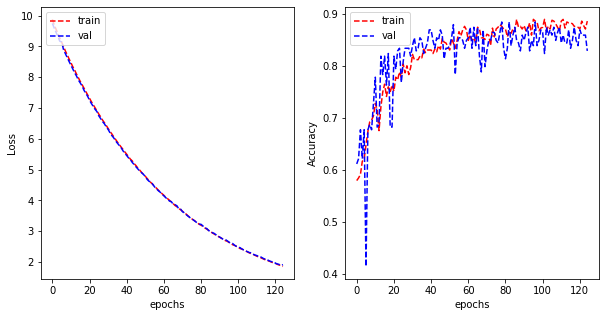

In [275]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_CV.history['loss'], 'r--')
plt.plot(history_CV.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_CV.history['categorical_accuracy'], 'r--')
plt.plot(history_CV.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Save model

In [277]:
# Original model without tuning
model_cancer.save("cancer_base_model")

# Model with regularization
model_cancer_reg.save("cancer_reg_base_model")

# Model with dropout
model_cancer_drop.save("cancer_dropout_base_model")
model_cancer_CV.save("cancer_CV_model")

INFO:tensorflow:Assets written to: cancer_base_model\assets
INFO:tensorflow:Assets written to: cancer_reg_base_model\assets
INFO:tensorflow:Assets written to: cancer_dropout_base_model\assets
INFO:tensorflow:Assets written to: cancer_CV_model\assets


## Testing the final model
The model tuning by dropout seems to have the best performance

In [156]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 198 validated image filenames belonging to 2 classes.


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [157]:
model_cancer_drop.evaluate(test_generator)

198/198 [==============================] - 0s 934us/step - loss: 0.3394 - categorical_accuracy: 0.8535


[0.3394325375556946, 0.8535353541374207]

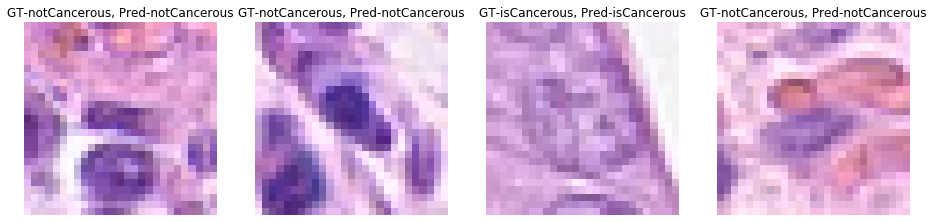

In [158]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer_drop.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

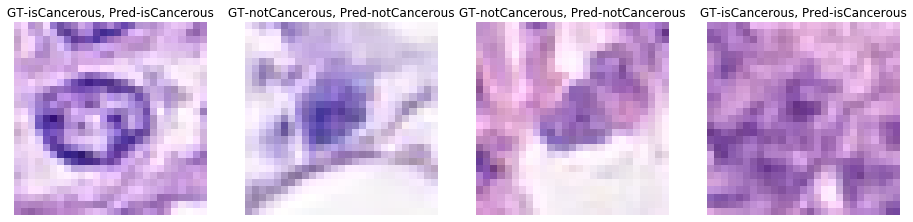

In [161]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

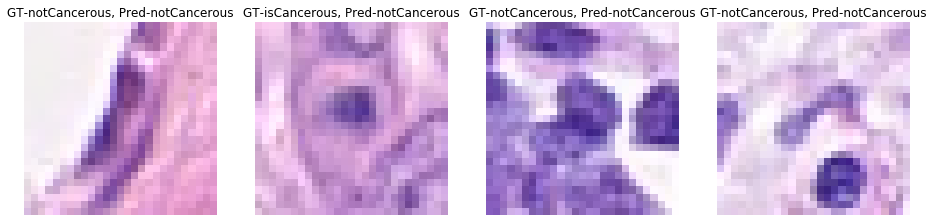

In [162]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer_reg.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')